In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Jun 20 07:43:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/fruits-360.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

In [ ]:
# dimensions of our images.
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '/content/fruits-360/Training'
validation_data_dir = '/content/fruits-360/Test'
nb_train_samples = 31688
nb_validation_samples = 10657
batch_size = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=9d1b523125f7eb14dab32e8b79499fb62a8d3d6645fbb0b3d6f72b8ecbe50a96
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [ ]:
from keras.applications.resnet import ResNet50  
#import inception with pre-trained weights. do not include fully #connected layers
inception_base = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = inception_base.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
# and a fully connected output/classification layer
predictions = Dense(131, activation='softmax')(x)
# create the full network so we can train on it
inception_transfer = Model(inputs=inception_base.input, outputs=predictions)
for layer in inception_base.layers:
    layer.trainable = False 

In [ ]:
opt=tf.keras.optimizers.RMSprop(
    learning_rate=0.0001,
    rho=0.9,
    momentum=0.9,
    epsilon=1e-07,
    centered=False,
    name="RMSprop" 
)
inception_transfer.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [18]:
history_pretrained = inception_transfer.fit(train_generator,epochs=25, shuffle = True, verbose = 1, validation_data = validation_generator)

Epoch 1/25
2116/2116 [==============================] - 747s 349ms/step - loss: 4.6048 - accuracy: 0.0302 - val_loss: 3.6337 - val_accuracy: 0.1078
Epoch 2/25
2116/2116 [==============================] - 732s 346ms/step - loss: 3.4984 - accuracy: 0.1087 - val_loss: 3.2850 - val_accuracy: 0.1455
Epoch 3/25
2116/2116 [==============================] - 728s 344ms/step - loss: 3.2497 - accuracy: 0.1377 - val_loss: 3.1966 - val_accuracy: 0.1220
Epoch 4/25
2116/2116 [==============================] - 741s 350ms/step - loss: 3.1044 - accuracy: 0.1671 - val_loss: 3.1400 - val_accuracy: 0.1698
Epoch 5/25
2116/2116 [==============================] - 743s 351ms/step - loss: 2.9270 - accuracy: 0.2018 - val_loss: 2.7705 - val_accuracy: 0.2383
Epoch 6/25
2116/2116 [==============================] - 736s 348ms/step - loss: 2.7980 - accuracy: 0.2232 - val_loss: 2.7427 - val_accuracy: 0.2470
Epoch 7/25
2116/2116 [==============================] - 731s 345ms/step - loss: 2.7116 - accuracy: 0.2444 - val_

In [19]:
inception_transfer.evaluate(validation_generator,verbose=2)

709/709 - 72s - loss: 2.2789 - accuracy: 0.3070


[2.278852701187134, 0.30699047446250916]

In [21]:
inception_transfer.save('/content/fruits-360/resnet.h5')


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
model=tf.keras.models.load_model('/content/fruits-360/resnet.h5')
batch_size = 16
num_of_test_samples=22688
# Y_pred=model.predict(validation_generator)
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = model.predict_generator(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
cm=confusion_matrix(validation_generator.classes, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


709/709 [==============================] - 69s 97ms/step


In [25]:
print(cm)

[[ 1  0  0 ...  0  9  1]
 [ 1  0  2 ...  0  7  0]
 [ 2  0  0 ...  0  5  2]
 ...
 [ 3  0  1 ...  0  8  1]
 [ 0  0  0 ...  0  9  3]
 [ 1  0  1 ...  0 10  1]]


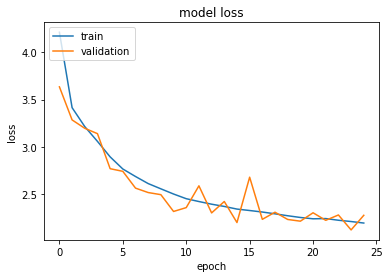

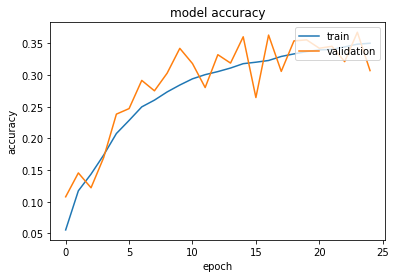

In [27]:
import matplotlib.pyplot as plt
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(validation_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.01      0.01       164
           1       0.00      0.00      0.00       148
           2       0.00      0.00      0.00       160
           3       0.01      0.01      0.01       164
           4       0.00      0.00      0.00       161
           5       0.00      0.00      0.00       164
           6       0.00      0.00      0.00       152
           7       0.00      0.00      0.00       164
           8       0.01      0.01      0.01       164
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       166
          11       0.02      0.01      0.01       164
          12       0.01      0.01      0.01       219
          13       0.02      0.01      0.01       164
          14       0.00      0.00      0.00       143
          15       0.00      0.00      0.00       166
          16       0.00      0.00      0.00       166
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
